# Topic Modeling - Mallet LDA


Author: Ryan Timbrook (RTIMBROO)<br>
DATE: 11/24/2019<br>
Topic: Perform Mallet Latent Semantic Analysis (LDA) on Congress Floor Debate<br>

## 1. Objective
_____________________________________________________________________________________________
Topic Modeling

LDA is an algorithm that can “summarize” the main topics of a text collection, now you are asked to use this algorithm to analyze the main topics in the floor debate of the 110th Congress (House only). According to political scientists, there are usually 40-50 common topics going on in each Congress. Tune the number of topics and see if LDA can get you the common topics, such as defense, education, healthcare, economy, etc.

The data set “110” consists of four subfolders. For the subfolder names, “m” means “male”, “f” means “female”, “d” means “democrat”, “r” means “republican”. You can merge all of them into one folder to run Mallet LDA.

There are a few other parameters you can tune, such as ngram. You can decide what parameters to use and explain your decision in the report.
 
Interpreting topic clustering results is very difficult. See if this article “Reading Tea Leaves” may help you. http://www.umiacs.umd.edu/~jbg/docs/nips2009-rtl.pdf. The recommended readings are also great examples to demonstrate how to articulate topic modeling results. 

This is a fairly large data set (100M pure text, more than 400 files). 

### Topic Modeling References
* [sklearn LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [Topic Modeling with SciKit Learn](https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730)
* [Complete Guide to Topic Modeling](https://nlpforhackers.io/topic-modeling/)
* [Topic Modelling with SciKit-learn -- Derek Greene University College Dublin](http://derekgreene.com/slides/topic-modelling-with-scikitlearn.pdf)


___________________________________________________________________________________________
## FOR RUNNING IN GOOGLE COLAB ONLY ##

In [1]:
# toggle for working with colab
isColab = False

In [2]:
#*ONLY RUN WHEN WORKING ON COLAB*
#===================================================
# mount google drive for working in colab

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# working within colab, set base working directory
#base_dir = "./gdrive/My Drive/IST707_PRJ_Realestate/buy_rent_sell/"

# validate directory mapping
#ls f'{base_dir}'

# upload custome python files
#from google.colab import files
#uploaded_files = files.upload()

# print files uploaded
#for f in uploaded_files.keys():
#  print(f'file name: {f}')

#isColab = True

______________________________________________________________________________________________
### Coding Environment Setup
Import packages

In [3]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
np.random.seed(42)

import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
import seaborn as sns #
import os
import sys
import io
from os import path
import re
import random
from datetime import date
from datetime import time
from datetime import datetime
import warnings
from timeit import default_timer               # performance processing time
import logging                                 # logging framework
warnings.filterwarnings('ignore')

# 
import nltk
nltk.download('wordnet')
from nltk import PorterStemmer
from nltk.stem import PorterStemmer 
stemmer = PorterStemmer()

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.stem.porter import *
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import itemfreq

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from scipy.stats import zscore


## IMPORTANT - you must install gensim first ##
## conda install -c anaconda gensim
from gensim import models, corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

## conda install -c conda-forge pyldavis
import pyLDAvis.sklearn as LDAvis
import pyLDAvis
pyLDAvis.enable_notebook()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rt310\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """


In [4]:
# custome python packages
import rtimbroo_utils_hw8 as br             # custome python helper functions

In [5]:
# get current date
now = datetime.utcnow().isoformat()
collection_date = re.findall('^[0-9]{4}-[0-9]{2}-[0-9]{2}',now)
collection_date

['2019-11-28']

In [6]:
# set global properties
notebook_file_name = 'hw8_topic_modeling'
report_file_name = 'hw8_topic_modeling'
app_name = 'hw8_topic_modeling'
log_level = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# setup working directory structure
# set global properties
if not isColab:
    dataDir = './data'
    outputDir = './output'
    configDir = './config'
    logOutDir = './logs'
    imageDir = './images'
    modelDir = './models'
    corpusDir = './corpus'
else:
    # working within colab
    dataDir = f'{base_dir}data'
    outputDir = f'{base_dir}output'
    configDir = f'{base_dir}config'
    logOutDir = f'{base_dir}logs'
    imageDir = f'{base_dir}images'
    modelDir = f'{base_dir}models'
    corpusDir = f'{base_dir}corpus'

In [7]:
# create base output directories if they don't exist
if not os.path.exists(outputDir): os.mkdir(outputDir)
if not os.path.exists(logOutDir): os.mkdir(logOutDir)
if not os.path.exists(imageDir): os.mkdir(imageDir)
if not os.path.exists(modelDir): os.mkdir(modelDir)
if not os.path.exists(corpusDir): os.mkdir(corpusDir)

In [8]:
# get a logger for troubleshooting / data exploration
logger = br.getFileLogger(logOutDir+'/',app_name+'_'+collection_date[0],level=log_level)

### Below section is for custom class definitions
-----------------------------------------------------------------------------------------------------------------

In [9]:
#--- Class Object for reading all files in a given directory and yeilding the processed list of word tokens
#
from gensim.utils import simple_preprocess
class GensimPreprocessDirTextFiles(object):
    
    def __init__(self, dirName):
        self.dirName = dirName
        
    def __iter__(self):
        for fileName in os.listdir(self.dirName):
            with open(os.path.join(self.dirName, fileName), encoding='latin') as f:
                for line in f:
                    # more info on simple_preprocess: https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html
                    yield simple_preprocess(line)
            

In [10]:
#--- Class Object that imports multiple files line by line and yields a corpus object
# For Lemmatization, gensim requires the pattern package. 
# do pip install pattern in your terminal or prompt before running this.
from gensim.utils import simple_preprocess, lemmatize
from smart_open import smart_open

class GensimBoWCorpus(object):
    
    def __init__(self, dirName, dictionary, lemmatize=False, train_test='train'):
        self.dirName = dirName
        self.dictionary = dictionary
        self.isLemmatize = lemmatize
        self.train_test = train_test
        
        
    def __iter__(self):
        global train_cong_dict
        global test_cong_dict
        
        for fileName in os.listdir(self.dirName):
            
            for line in smart_open(os.path.join(self.dirName, fileName), encoding='latin'):
            
                # tokenize line
                tokens = simple_preprocess(line, deacc=True)



                # lemmatize tokens
                if self.isLemmatize:
                    tokens = self.lemmatize_stemming(tokens)
                    #logger.info(f'look at lemmatized: {tokens}')

                #lem_toks = self.lemmatize_stemming(tokens)
                
                # create bag of words
                bow = self.dictionary.doc2bow(tokens, allow_update=True)

                # update
                if self.train_test == 'train':
                    train_cong_dict.merge_with(self.dictionary)
                else:
                    test_cong_dict.merge_with(self.dictionary)

                # lazy return the bow
                yield bow
                    
    def lemmatize_stemming(self, text):
        stems = []
        for word in text:
            try:
                lem_word = lemmatize(word,allowed_tags=re.compile('(NN|JJ|RB|VB)'))

                if lem_word:
                    stems = stems + [lem_word[0].split(b'/')[0].decode('utf-8')]
            except BaseException as be:
                logger.error(f'***ERROR***: Caught BaseException: {be} | word_idx:[{i}] | word:[{word}]')
                continue

        return stems
        

### Below section is for local custom functions
-----------------------------------------------------------------------------------------------------------------

[NLTK 3.4.5](https://www.nltk.org/index.html)
* [nltk.stem.wordnet](https://www.nltk.org/_modules/nltk/stem/wordnet.html)
* [WordNetLemmatizer lemmatize](https://www.nltk.org/api/nltk.stem.html?highlight=wordnetlemmatizer#nltk.stem.wordnet.WordNetLemmatizer.lemmatize)

In [11]:
# nltk lemmatize implementation
# topic keyword choice - Verbs(v)
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [12]:
# gensim lemmatize function -- requires pattern package
# lemmatize each word to its root form, keeping only nouns(NN), adjectives(JJ), verbs(VB) and adverbs(RB).
# We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences
# this implementation allows Nouns(NN), Adjectives(JJ), and Pronouns(RB) - topic keyword choices
def gen_lemmatize(text):
        stems = []
        tokens = text.split(' ')
        for i,word in enumerate(tokens):
            try:
            
                lem_word = lemmatize(word,allowed_tags=re.compile('(NN|VB|JJ|RB)'))

                if lem_word:
                    stems = stems + [lem_word[0].split(b'/')[0].decode('utf-8')]
                    
            except BaseException as be:
                logger.error(f'***ERROR***: Caught BaseException: {be} | word_idx:[{i}] | word:[{word}]')
                continue

        return ' '.join(stems)

## 2. OBTAIN the data   
________________________________________________________________________________________________


## 2.1 Clean Document Text
---------------------------------------------------------------------------------------------
Clean Congress document text as preprocessing vectorization step

1: Remove document tags:<br>
    * <DOC><\/DOC>
    * <DOCNO></DOCNO>
    * <TEXT></TEXT>
2: Remove document header: remove the line within tag <DOCNO><br>
    * <DOCNO>xxxxx</DOCNO>
3: Lower case text<br>
4: Remove custom stop words unique to these congressional documents such as:<br>
    * chariwoman, chairman, speaker, mr., ms., madam, etc...
    * US. States who the speaker is representing
    * The speaker, i.e. the persons name identified in the <DOCNO> heading
5: Remove nltk stopwords<br>
6: Remove non-alpha text<br>

In [13]:
# clean congress files of tags
# <DOC> </DOC>
# <DOCNO> </DOCNO>
# <TEXT> </TEXT>
openDoc = '<DOC>'
closeDoc = '</DOC>'
openDocNo = '<DOCNO>'
closeDocNO = '</DOCNO>'
openText = '<TEXT>'
closeText = '</TEXT>'
tagsPattern = re.compile(r'<.*?>')
tagsDocNoPattern = re.compile(r'^<DOCNO>')

# custom stop words
congress_stopwords = {'chairwoman','chairman','speaker','mr.','ms.','madam'}
docno_name = ''
# list of US States to be filtered out of document text
us_states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

# data directories for congress documents to be analyzed for topic modeling
path = f'{dataDir}/110_merged'
cleanPathTrain = f'{dataDir}/110_merged_clean/train'
cleanPathTest = f'{dataDir}/110_merged_clean/test'
cleanPathBuildTrain = f'{dataDir}/110_merged_clean/build_train'
cleanPathBuildTest = f'{dataDir}/110_merged_clean/build_test'
if not os.path.exists(cleanPathTrain): os.makedirs(cleanPathTrain)
if not os.path.exists(cleanPathTest): os.makedirs(cleanPathTest)
if not os.path.exists(cleanPathBuildTrain): os.makedirs(cleanPathBuildTrain)
if not os.path.exists(cleanPathBuildTest): os.makedirs(cleanPathBuildTest)    

In [14]:
#---
# function to clean congress data files optimized for topic modeling
#---
def clean_text(text):
    logger.debug(f'clean_text: --- text to clean:\n {[text]}')
    cleaned_text = []
    text = re.sub(r'\n', ' ',text)
    
    # remove tags
    text = tagsPattern.sub('',text)
    
    # lower case
    text = text.lower()
    lower_states = [s.lower() for s in us_states]
    
    # remove states as stop_words
    for state in us_states:
        m = re.search(r"f'{state}'",text)
        if m:
            print(f'found state match: {m}')

    # remove stop words
    if len(text) > 0:
        # lower case & tokenize line
        text_tokens = wordpunct_tokenize(text)

        # remove stop words
        stop_words = set(stopwords.words('english'))
        custom_stop_words = set(list(congress_stopwords) + [s.lower() for s in us_states])
        new_list = set(list(stop_words) + list(custom_stop_words))
        
        cleaned_text = [t for t in text_tokens if t not in new_list and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]

        logger.debug(f'clean_text: --- cleaned text:\n {[cleaned_text]}')
    
    return ' '.join(cleaned_text)

<>:32: DeprecationWarning: invalid escape sequence \-
<>:32: DeprecationWarning: invalid escape sequence \-
<>:32: DeprecationWarning: invalid escape sequence \-
<ipython-input-14-90fad3c4d24b>:32: DeprecationWarning: invalid escape sequence \-
  cleaned_text = [t for t in text_tokens if t not in new_list and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]


In [15]:
# - get individual file document text start - end indexs
def get_doc_file_mapping(file_lines):
    logger.info(f'get_doc_file_mapping: file_line len = {[len(file_lines)]}')
    file_docs_map = []
    doc_id = 0
    doc_start_idx = 0
    doc_end_idx = 0
        
    for i,line in enumerate(file_lines):
        line = re.sub(r'\n', '',line)
        if line == openText:
            doc_id += 1
            doc_start_idx = i+1
        elif line == closeText:
            doc_end_idx = i-1
            file_docs_map.append({doc_id:(doc_start_idx,doc_end_idx)})
            doc_start_idx = 0
            doc_end_idx = 0    
        else:
            pass
        
    return file_docs_map

In [16]:
# get the files docno name
def get_docno_name(lines):
    for line in lines:
        
        if not re.search(tagsDocNoPattern,line):
            pass
        else:
            docno = line.split(' ')
            docno_name = docno[1]
            break
    
    return docno_name[:-1].lower()

In [17]:
# - clean and write a new text file for post pipeline processing
# -
def clean_write_docs(files,dirpath,clean_path):
    for i,file in enumerate(files):
        with open(f'{dirpath}/{file}','r') as f:
            with open(f'{clean_path}/{file}', 'w+') as w:
                
                lines = f.readlines()
                #print(len(lines))
                
                # get docno name - add it to custom stop words
                congress_stopwords.add(get_docno_name(lines))
                
                # get individual document text indexing from file
                docs_mapping = get_doc_file_mapping(lines)
                logger.debug(f'file: {file} | doc index mappings:{docs_mapping}')
                
                #break
                
                # flatten document into one line for vectorization
                for doc_map in docs_mapping:
                    
                    for k,v in doc_map.items():
                        # clean text doc - write to single file
                        
                        doc_lines = []
                        for i in range(v[0],v[1]+1):
                            #print(lines[i])
                            doc_lines.append(clean_text(lines[i]))
                        
                        # write document line to file    
                        w.write(" ".join(doc_lines))
                        w.write('\n')

In [20]:
### ONLY RUN ONCE ###
# Run preprocessing cleaning of congressional documentation
#for dirpath, dirs, files in os.walk(path):
    #logger.info(f'file count: {len(files)}')
    
    # hold out 10 of congress documents for lda model topic prediction evaluation
    #doc_hold_out_num = round(.10 * len(files))
    
    #logger.debug(f'doc_hold_out_num: {doc_hold_out_num}')
    
    # test congress docs
    #test_samples = random.sample(files,doc_hold_out_num)
    #logger.debug(f'test samples({len(test_samples)}):\n{test_samples}')
    
    # train congress docs
    #train_samples = [file for file in files if file not in test_samples]
    #logger.debug(f'train samples({len(train_samples)}):\n {train_samples}')
    
    # small samples set for initial building of model
    #build_samples = random.sample(files,round(.2 * len(files)))
    #logger.info(f'build_samples size: {len(build_samples)}')
    
    #build_test_samples = random.sample(build_samples,round(.2 * len(build_samples)))
    #logger.info(f'build_test_samples size: {len(build_test_samples)}')
    
    #build_train_samples = [file for file in build_samples if file not in build_test_samples]
    #logger.info(f'build_train_samples size: {len(build_train_samples)}')
    
    #break
    
    #----- Training Sample Set -------#
    #clean_write_docs(train_samples,dirpath,cleanPathTrain)
    
    #----- Training Sample Set -------#
    #clean_write_docs(test_samples,dirpath,cleanPathTest)
    
    #----- Build Training Sample Set -------#
    #clean_write_docs(build_train_samples,dirpath,cleanPathBuildTrain)
    
    #----- Build Testing Sample Set -------#
    #clean_write_docs(build_test_samples,dirpath,cleanPathBuildTest)

## 3. Topic Modeling
-------------------------------------------------------------------------------------------

Techniques:
* Latent Dirichlet Allocation (LDA)
    * LDA is a algorithm used to discover the topics that are present in a corpus
    * Its foundations are **Probabilistic Graphical Models**
        * Top Python libraries for LDA are:
            * Gensim
            * 
* Non-negative Matrix Factorization (NMF)
    * Based on **Linear Algebra**

Both algorithms are able to return the documents that belong to a topic in a corpus and the words that belong to a topic. They aim to produce 2 matricies:
* A document to topic matrix
* A word to topic matrix
And when multiplied together reproduce the bag of words matrix with the lowest error


### Get Cleaned Congress Data Corpus
-----------------------------------------------------------------------------------------------
Data Clean Path Versions:
* cleanPathBuildTrain -- training data sample for initial build
* cleanPathBuildTest  -- testing data sample for initial build
* cleanPathTrain      -- 90% full training data set
* cleanPathTest       -- 10% test data for unseen document topic labeling

In [21]:
def get_data_filename_path(path):
    _file_names = []
    _dir_file_names = []
    
    for fileName in os.listdir(f'{path}'):
        _file_names.append(fileName)
        _dir_file_names.append(f'{path}/{fileName}')
        
    return _file_names, _dir_file_names

In [22]:
# get files from path
build_train_data_paths = get_data_filename_path(cleanPathBuildTrain)
build_test_data_paths = get_data_filename_path(cleanPathBuildTest)
train_data_paths = get_data_filename_path(cleanPathTrain)
test_data_paths = get_data_filename_path(cleanPathTest)

### 3.1 Topic Modeling - Gensim package
-------------------------------------------------------------------------------------------------
Gensim is a Natural Language Processing package that does 'Topic Modeling for Humans'.
It is a state-of-the-art package for processing texts, working with word vector models such as Word2Vec, FastText, and for building topic models.

Resources:
* [Gensim Tutorial](https://www.machinelearningplus.com/nlp/gensim-tutorial/)
* [gensim 3.8.1 python package](https://pypi.org/project/gensim/)
    * Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community.<br>
* [gensim models.ldamodel](https://radimrehurek.com/gensim/models/ldamodel.html)
* [How to represent Topic Models](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

In [31]:
# - Gets congress cleaned corpus data files from drive
# - Runs additional text transformation step of lemmatization
def get_data_documents(paths, doc_type='train'):
    _documents = []
    _doc_idxs = []
    _file_names = []
    _doc_cnt = 0
    _file_cnt = 0
    with br.elapsed_timer() as elapsed:
        for file_dir_path in paths:
            _file_cnt +=1
            
            for line in smart_open(file_dir_path, encoding='latin'):
                _doc_idxs.append(_doc_cnt)
                _doc_cnt +=1
                lem_line = gen_lemmatize(line)
                logger.debug(f'doc_no:{[_doc_cnt]} | doc_path: {file_dir_path} | pre_lemmatize word cnt:{[len(line)]} | post_lemmatize word cnt:{[len(lem_line)]}')

                _documents.append(lem_line)
                _file_names.append(file_dir_path.split('/')[-1])

                #if train_doc_cnt == 3: break

            logger.debug(f'{doc_type}_file:{[_file_cnt]} | {doc_type}_doc_cnt:{[_doc_cnt]} | elapsed time:{[round(elapsed(),5)]}')   
            #break

    logger.info(f'{doc_type}_documents len: {len(_documents)} | of {doc_type}_file_cnt: {[_file_cnt]} | total elapsed time:{[round(elapsed(),5)]}')    
    
    df = pd.DataFrame()
    
    logger.info(f'_file_names len:{len(_file_names)} | _doc_idxs len: {len(_doc_idxs)} | _documents len: {len(_documents)}')
    
    df['file_name']=_file_names
    df['doc_id']=_doc_idxs
    df['document_text']=_documents
    
    return _documents, df

In [33]:
train_documents = get_data_documents(train_data_paths[1], doc_type='train')
train_documents_df = train_documents[1]
train_documents = train_documents[0]
train_documents_df.head()

train_documents len: 40433 | of train_file_cnt: [429] | total elapsed time:[1518.20414]
_file_names len:40433 | _doc_idxs len: 40433 | _documents len: 40433


,file_name,doc_id,document_text
0,110_abercrombie_x_hi.txt,0,point thank mike turner work committee right g...
1,110_abercrombie_x_hi.txt,1,move suspend rule agree resolution re recogniz...
2,110_abercrombie_x_hi.txt,2,yield time consume rise today recognize pearl ...
3,110_abercrombie_x_hi.txt,3,want compliment wittman want thank perhaps coi...
4,110_abercrombie_x_hi.txt,4,rise today wake news come unite state policy i...


In [34]:
test_documents = get_data_documents(test_data_paths[1], doc_type='test')
test_documents_df = test_documents[1]
test_documents = test_documents[0]
test_documents_df.head()

test_documents len: 17537 | of test_file_cnt: [177] | total elapsed time:[608.6277]
_file_names len:17537 | _doc_idxs len: 17537 | _documents len: 17537


,file_name,doc_id,document_text
0,110_ackerman_x_ny.txt,0,september addition enormous loss human life va...
1,110_ackerman_x_ny.txt,1,thank name cite list new yorker opposed origin...
2,110_ackerman_x_ny.txt,2,friend republican side pride tough terror righ...
3,110_ackerman_x_ny.txt,3,speaker urge colleague join former republican ...
4,110_ackerman_x_ny.txt,4,thank gentleman new york equity side issue fir...


In [35]:
logger.info(f'train_documents memory size: [{sys.getsizeof(train_documents)} bytes]')

train_documents memory size: [361288 bytes]


In [36]:
logger.info(f'train_documents memory size: [{sys.getsizeof(train_documents)/1024/1000} MB]')
logger.info(f'test_documents memory size: [{sys.getsizeof(test_documents)/1024/1000} MB]')

train_documents memory size: [0.3528203125 MB]
test_documents memory size: [0.1372890625 MB]


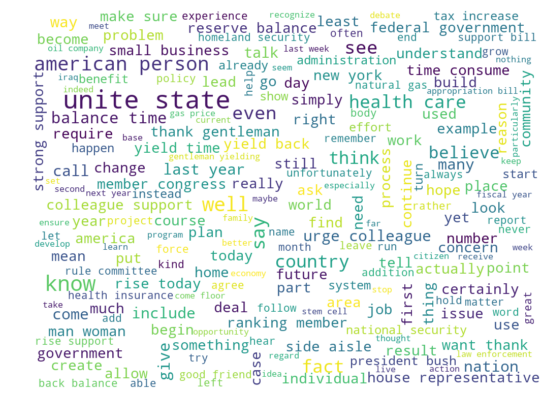

In [37]:
# wordcloud of complete training set
br.wordcloud_draw(train_documents_df['document_text'], color='white',max_words=200)

In [38]:
# create gensim dictionary from preprocessed cleaned congress documents
with br.elapsed_timer() as elapsed:
    train_dict = corpora.Dictionary([simple_preprocess(line) for line in train_documents])
    train_corp = [train_dict.doc2bow(simple_preprocess(line)) for line in train_documents]
    logger.info(f'Elapsed time building train_dict and train_corp from train_documents: {[round(elapsed(),5)]}')

Elapsed time building train_dict and train_corp from train_documents: [51.02899]


In [39]:
# create gensim dictionary from preprocessed cleaned congress documents
with br.elapsed_timer() as elapsed:
    test_dict = corpora.Dictionary([simple_preprocess(line) for line in test_documents])
    test_corp = [test_dict.doc2bow(simple_preprocess(line)) for line in test_documents]
    logger.info(f'Elapsed time building test_dict and test_corp from test_documents: {[round(elapsed(),5)]}')

Elapsed time building test_dict and test_corp from test_documents: [15.09078]


In [40]:
# show sampling of word weights in corpus
# train
for i, doc in enumerate(train_corp):
    logger.debug([[train_dict[id], freq] for id, freq in doc])
    if i == 2: break
# test
for i, doc in enumerate(train_corp):
    logger.debug([[train_dict[id], freq] for id, freq in doc])
    if i == 2: break

In [41]:
# take a look at the first 5 token_id and count for each line
# train
for i, line in enumerate(train_corp):
    logger.debug(f'first 5 token_id and count for each line train_corp:\n{line}')
    if i == 5: break

for i, line in enumerate(test_corp):
    logger.debug(f'first 5 token_id and count for each line test_corp:\n{line}')
    if i == 5: break


In [42]:
from gensim import models
# create the TF-IDF model
gen_tfidf = models.TfidfModel(train_corp, smartirs='ntc')
# show a sample of the weights
for i,doc in enumerate(gen_tfidf[train_corp]):
    logger.info(f'tfidf weights:\n{[[train_dict[id], np.around(freq, decimals=2)] for id, freq in doc ]}')
    if i == 2: break

tfidf weights:
[['accountability', 0.07], ['advantage', 0.09], ['alone', 0.14], ['also', 0.02], ['approve', 0.15], ['author', 0.09], ['back', 0.03], ['battle', 0.08], ['bearing', 0.13], ['bill', 0.03], ['body', 0.05], ['bring', 0.03], ['brunt', 0.14], ['commentary', 0.43], ['committee', 0.03], ['concentrate', 0.13], ['congress', 0.02], ['consider', 0.05], ['cover', 0.2], ['democrat', 0.05], ['demonstrate', 0.09], ['diminish', 0.1], ['disapprove', 0.14], ['dod', 0.12], ['draw', 0.09], ['end', 0.21], ['engage', 0.07], ['english', 0.1], ['enter', 0.08], ['execute', 0.11], ['family', 0.03], ['far', 0.06], ['field', 0.07], ['fight', 0.06], ['force', 0.05], ['get', 0.02], ['give', 0.03], ['go', 0.02], ['government', 0.03], ['important', 0.03], ['intent', 0.08], ['interested', 0.09], ['iraq', 0.09], ['issue', 0.03], ['july', 0.08], ['kill', 0.14], ['kind', 0.06], ['man', 0.05], ['marine', 0.17], ['mentioned', 0.07], ['mike', 0.1], ['name', 0.12], ['naming', 0.11], ['need', 0.02], ['obtain', 0

In [43]:
# build dictionary
#with br.elapsed_timer() as elapsed:
   # train_congress_text = GensimPreprocessDirTextFiles(f'{cleanPathTrain}')
   # train_tokenized_data = [line for line in train_congress_text]
   # train_cong_dict = corpora.Dictionary(train_tokenized_data)
   # logger.info(f'Elapsed time building train dictionary: {elapsed()}')
    
logger.debug(f'train_dict.token2id:\n{train_dict.token2id}')
logger.debug(f'test_dict.token2id:\n{test_dict.token2id}')

In [44]:
# save gensim dictionary and corpus to disk
with br.elapsed_timer() as elapsed:
    # train
    train_dict.save(f'{corpusDir}/train_dict.dict')
    corpora.MmCorpus.serialize(f'{corpusDir}/train_corp.mm',test_corp)
    
    # test
    test_dict.save(f'{corpusDir}/test_dict.dict')
    corpora.MmCorpus.serialize(f'{corpusDir}/test_corp.mm',test_corp)
    
    logger.info(f'Elapsed time saving congress train and test dictionary and corpus to disk: {elapsed()}')

Elapsed time saving congress train and test dictionary and corpus to disk: 7.848296699999992


### Pull saved dictionary and model from hard disk
----------------------------------------------------------------------------------------------

In [45]:
# load previously saved to disk gensim dictionary and corpus objects
loaded_train_congress_dict = corpora.Dictionary.load(f'{corpusDir}/train_dict.dict')
loaded_train_congress_corpus = corpora.MmCorpus(f'{corpusDir}/train_corp.mm')
loaded_test_congress_dict = corpora.Dictionary.load(f'{corpusDir}/test_dict.dict')
loaded_test_congress_corpus = corpora.MmCorpus(f'{corpusDir}/test_corp.mm')

### Build LDA Topic Model - Gensim
-------------------------------------------------------------------------------------------------
gensim model packages:
* LdaModel
* LdaMulticore
gensim util packages:
* simple_preprocess
* lemmatize

class gensim.models.ldamodel.LdaModel(corpus=None, num_topics=100, id2word=None, distributed=False, chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, minimum_probability=0.01, random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None, dtype=<class 'numpy.float32'>

In [46]:
def format_topics_sentences(ldamodel=None, corpus=train_corp, texts=train_documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [47]:
# model parameters
num_topics = 40

In [48]:
# build the LDA model
# lda = LdaModel(common_corpus, num_topics=50, alpha='auto', eval_every=5)  # learn asymmetric alpha from data
with br.elapsed_timer() as elapsed:
    cong_lda_model = models.LdaModel(corpus=loaded_train_congress_corpus,
                                    num_topics=num_topics,
                                    id2word=loaded_train_congress_dict,
                                    distributed=False)
    logger.info(f'Elapsed time building lda model: {elapsed()}')

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

In [49]:
# print lda topics
for idx in range(num_topics):
    logger.debug(f'Topic #{idx}: {cong_lda_model.print_topic(idx,10)}')

#### Get the Dominant topic and its percentage contribution in each document
Identifies which document belongs predominantly to which topic

In [50]:
# Get the Dominant topic and its percentage contribution in each document
# identifies which document belongs predominantly to which topic
df_topic_sents_keywords = format_topics_sentences(ldamodel=cong_lda_model, corpus=train_corp, texts=train_documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)
save_as = f'{outputDir}/gensim_lda_dominant_topic_report.csv'
df_dominant_topic.to_csv(save_as,index=False)

In [51]:
df_dominant_topic = df_dominant_topic.sort_values(by=['Dominant_Topic','Topic_Perc_Contrib'], ascending=False)
save_as = f'{outputDir}/gensim_lda_dominant_topic_report.csv'
df_dominant_topic.to_csv(save_as,index=False)

df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
5272,5272,39.0,0.4245,"francisco, engage, lake, quite, something, res...",campbell say great difference talk money money...
30902,30902,39.0,0.2596,"francisco, engage, lake, quite, something, res...",conclusion observe eastern county secede union...
17404,17404,39.0,0.2439,"francisco, engage, lake, quite, something, res...",ask unanimous consent house adjourn today adjo...
39122,39122,39.0,0.2348,"francisco, engage, lake, quite, something, res...",move strike last word confused gentleman state...
5362,5362,39.0,0.2328,"francisco, engage, lake, quite, something, res...",campbell qualify virtue fact elect person dist...


#### Frequency Distribution of Word Counts in Documents
Plots the documents word counts distribution

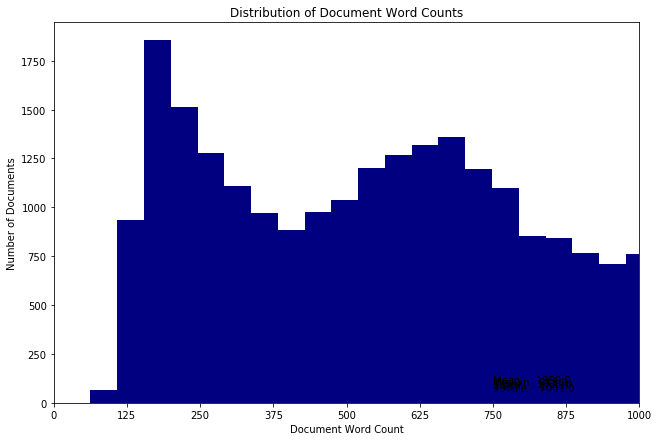

In [52]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10.5,7))
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
#plt.tick_params(size=12)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts')#, fontdict=dict(size=15)
plt.savefig(f'{imageDir}/gensim_lds_topic_distro_1.png')
plt.show()

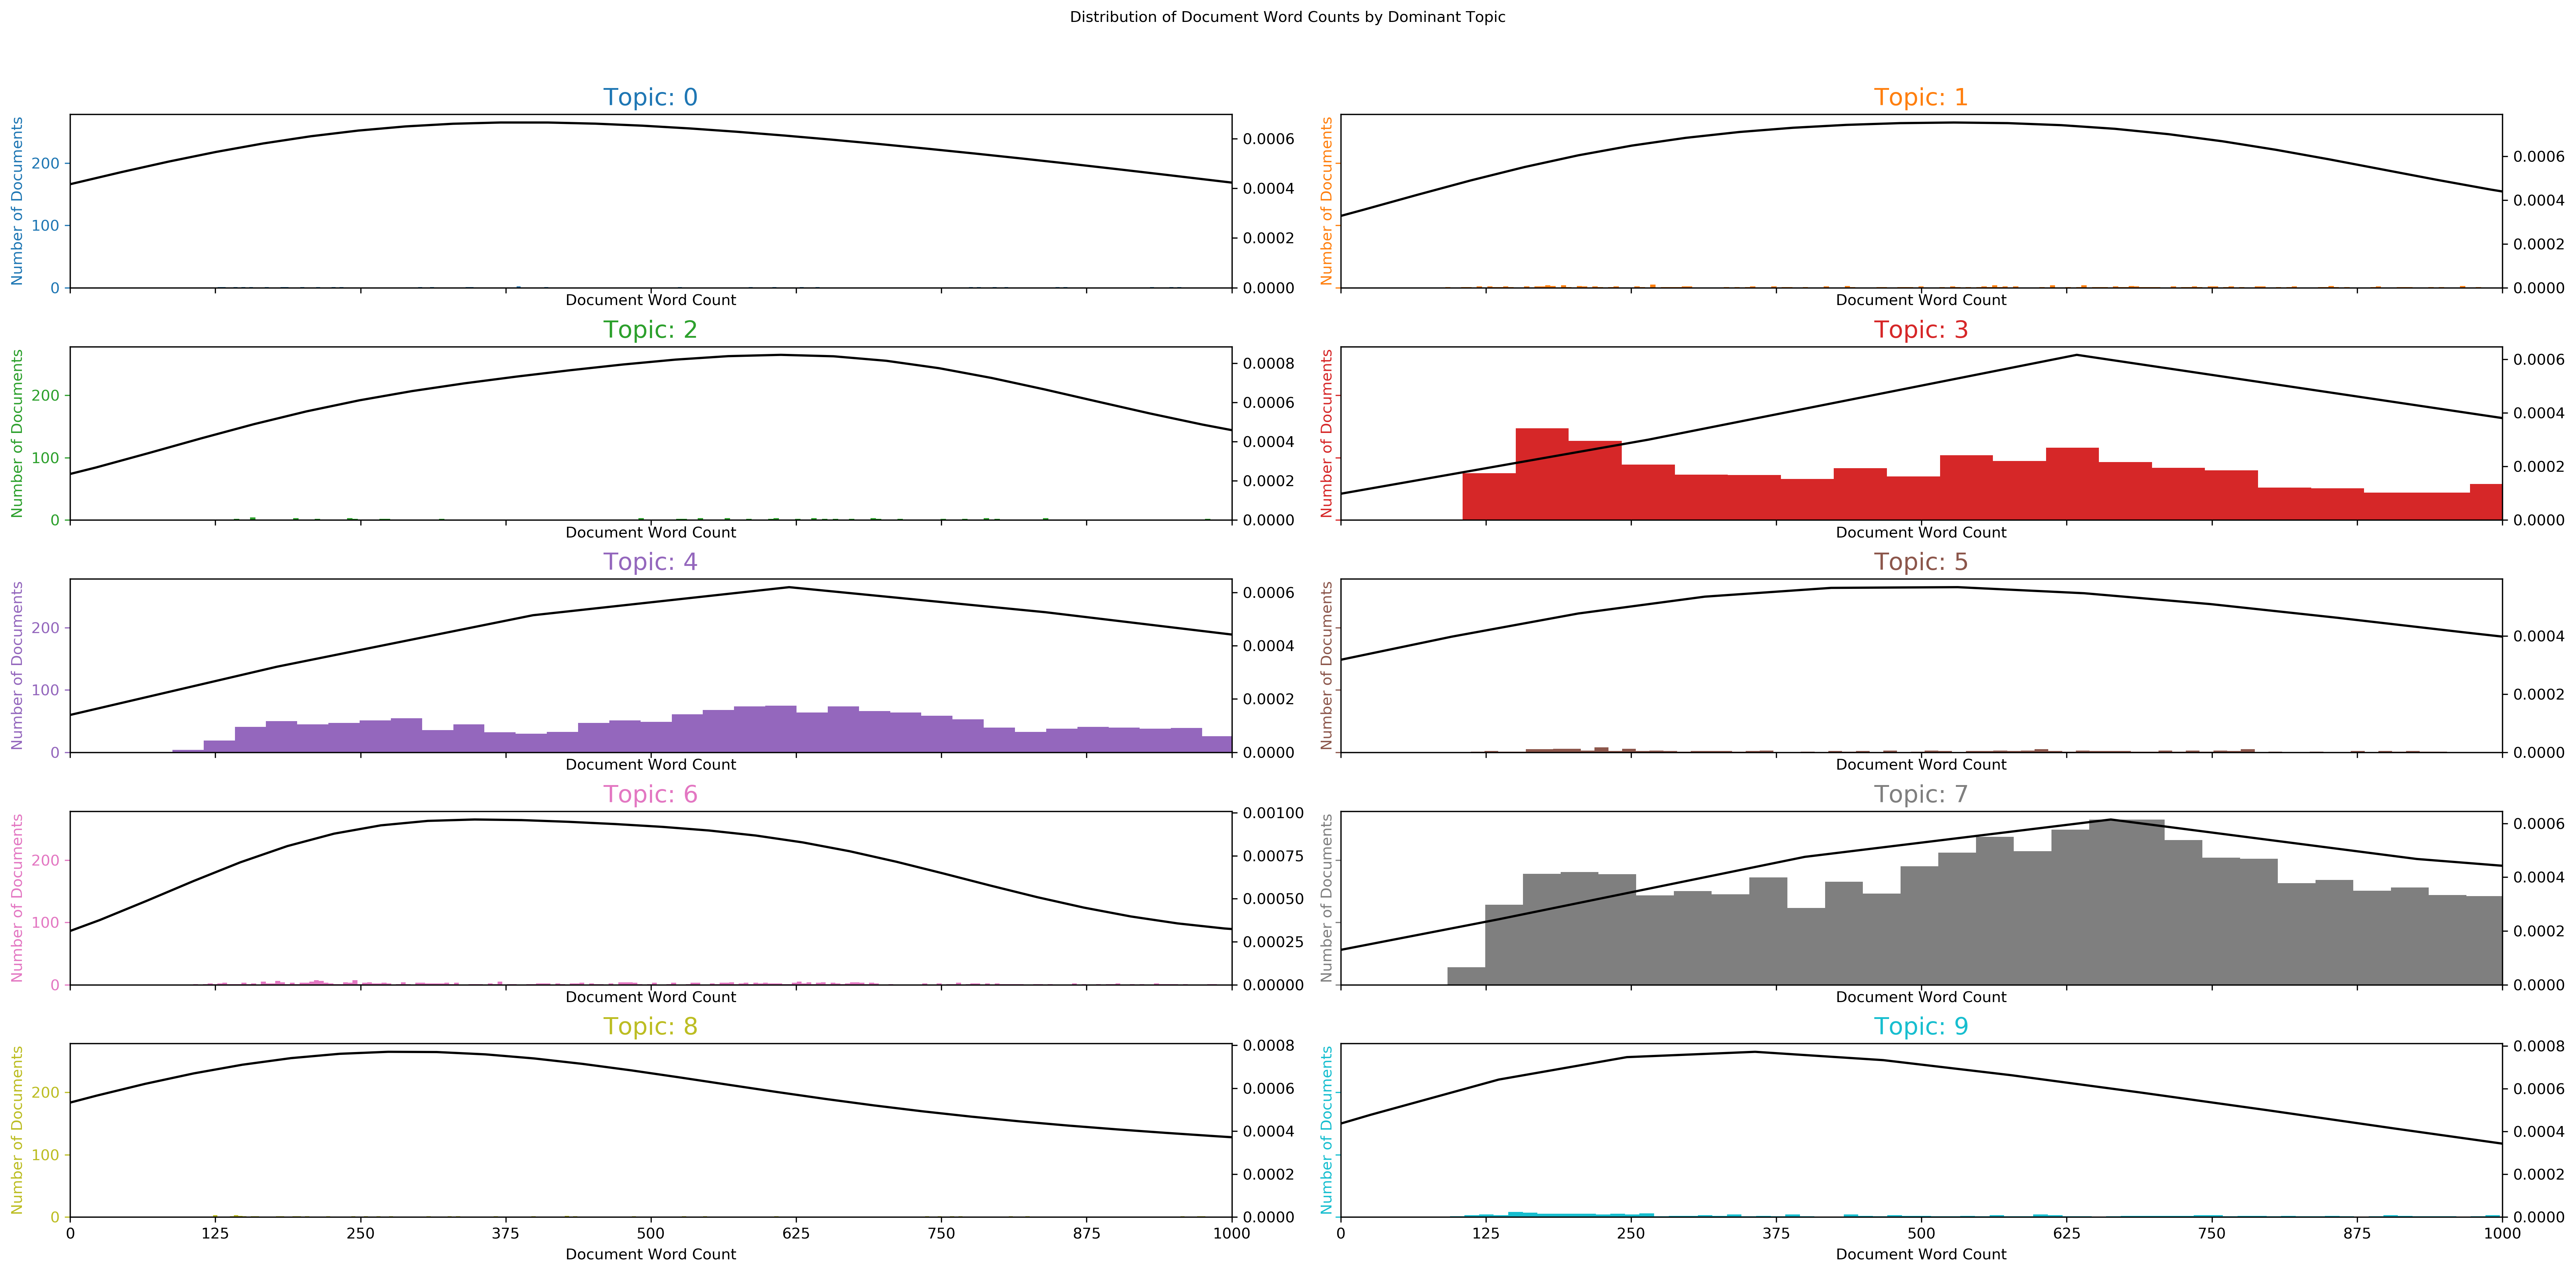

In [53]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(24,12), dpi=300, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=10)
plt.savefig(f'{imageDir}/gensim_lds_topic_distro_2.png')
plt.show()

#### Word Clouds of Top N Keywords in Each Topic

In [54]:
cong_lda_model.show_topics(formatted=False)
len(cong_lda_model.show_topics(formatted=False))

10

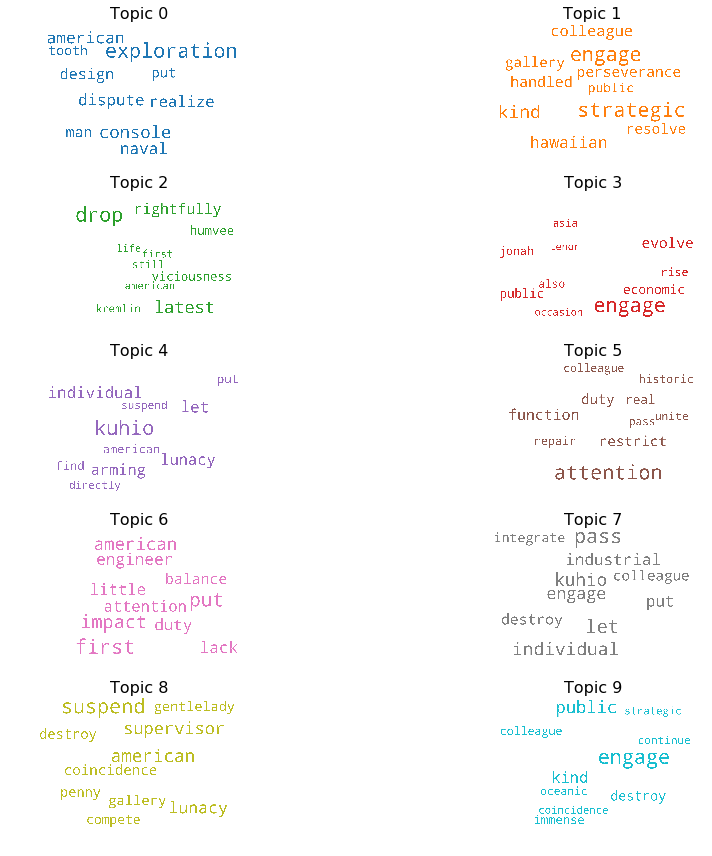

In [55]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=3000,
                  height=2000,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = cong_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(16,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig(f'{imageDir}/gensim_lds_topic_word_cloud.png')
plt.show()

#### Word Counts of Topic Keywords
keywords, importance (weights) - and how frequently the words have appeared in the document
Plotting of word counts and the weights of each keyword in the same chart
* what words occur in multiple topics and the ones whose relative frequency is more than the weight - these turn out to be less important
    * these words can be added to the stop-words list for tunning

Resources:
* [gensim.similarities](https://radimrehurek.com/gensim/similarities/termsim.html) - Term similarity queries

In [58]:
#from gensim import similarities, SparseTermSimilarityMatrix
# testing similarities
#gensim_lda_index = similarities.MatrixSimilarity(cong_lda_model[loaded_train_congress_corpus])
 
# Let's perform some queries
#similarities = gensim_lda_index[cong_lda_model[loaded_test_congress_corpus]]
# Sort the similarities
#similarities = sorted(enumerate(similarities), key=lambda item: -item[1])
 
# Top most similar documents:
#logger.info(f'top most similar documents: \n{similarities[:10]}')

# Let's see what's the most similar document
#document_id, similarity = similarities[0]
#logger.inf(f'most similar document: document_id:{[document_id]} | similarity:{[similarity]}')

### 3.2 Topic Modeling - SciKit Learn package
--------------------------------------------------------------------------------------------------


Resources:
* [sklearn.decomposition.LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [Topic Modelling with SciKit-learn - Insight, Derek Greene -- University College Dublin](http://derekgreene.com/slides/topic-modelling-with-scikitlearn.pdf)
* [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
* [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [59]:
# function to display the topic model top 10 feature words
def display_topics(model, feature_names, no_top_words):
    top_ids = []
    top_words = []
    
    for topic_idx, topic in enumerate(model.components_):
        top_ids.append(str(topic_idx))
        logger.debug("Topic %d:" % (topic_idx))
        top_10 = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        top_words.append(top_10)
        logger.debug(top_10)
    
    top_df = pd.DataFrame()
    top_df['Topic']=top_ids
    top_df['Top_10_Features']=top_words
    
    return top_df
no_top_words = 10

In [60]:
# get files from path
train_file_names = []
train_dir_file_names = []
for fileName in os.listdir(f'{cleanPathBuildTrain}'):
    train_file_names.append(fileName)
    train_dir_file_names.append(f'{cleanPathBuildTrain}/{fileName}')

In [61]:
# vectorization parameters
no_features = 1000
max_df = 0.95
min_df = 2
max_features = no_features # None
vect_input = 'filename'
encoding = 'latin'
decode_error = 'strict'

#### Build a CountVectorizer data model

In [62]:
# ---- TRAIN VECTORIZER -----#
# build vectorizer from content
#train_documents or test_documents - in-memory content for training versus pulling from hard disk
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
train_tf_vectorizer = CountVectorizer(input='content',max_df=max_df, min_df=min_df, max_features=max_features,encoding=encoding)
train_tf_vec_model = train_tf_vectorizer.fit_transform(train_documents)
train_tf_vec_feature_names = train_tf_vectorizer.get_feature_names()
logger.info(f'train_tf_vec_model shape: [{train_tf_vec_model.shape}]')

train_tf_vec_model shape: [(40433, 1000)]


In [63]:
# ---- TEST VECTORIZER -----#
# ---- UNSEEN DOCUMENTS ----#
test_tf_vec = train_tf_vectorizer.transform(test_documents)
logger.info(f'test_tf_vec shape: [{test_tf_vec.shape}]')

test_tf_vec shape: [(17537, 1000)]


In [64]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
#tf_vectorizer = CountVectorizer(input=vect_input,max_df=max_df, min_df=min_df, max_features=max_features,encoding=encoding)
#tf = tf_vectorizer.fit_transform(train_dir_file_names)
#tf_feature_names = tf_vectorizer.get_feature_names()

In [65]:
# display vectorizer's sparse matrix head
train_cong_corpus_df = pd.DataFrame(train_tf_vec_model.toarray(),columns=train_tf_vec_feature_names)
train_cong_corpus_df.head()

,ability,able,absolutely,abuse,access,accomplish,accord,account,accountability,achieve,...,wound,wrong,year,yes,yesterday,yet,yield,yielding,york,young
0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,2,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build Topic Models
* [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)
* [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
* [LSI](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

**from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD**

#### Build a Latent Dirichlet Allocation Model
object parameters:
* LatentDirichletAllocation(n_components=10, doc_topic_prior=None, topic_word_prior=None, learning_method=’batch’, learning_decay=0.7, learning_offset=10.0, max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0, perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100, n_jobs=None, verbose=0, random_state=None)

Latent Dirichlet Allocation with online variational Bayes algorithm

In [66]:
# LDA algorithm parameters
n_topics = 40            # int, optional (default=10) - Number of Topics
max_iter=5
learning_method='online' # ‘batch’ | ‘online’, default=’batch’ -- Method used to update _component. Only used in fit method. In general, if the data size is large, the online update will be much faster than the batch update.
learning_offset=50.
random_state=42

In [67]:
# instantiate the lda object
lda = LatentDirichletAllocation(n_components=n_topics, 
                                max_iter=max_iter, 
                                learning_method=learning_method, 
                                learning_offset=learning_offset,
                                random_state=random_state)
# build the lda model
with br.elapsed_timer() as elapsed:
    train_cong_lda_model = lda.fit_transform(train_tf_vec_model)
    logger.info(f'Elapsed time training LDA mode: [{elapsed()}]')
    logger.info(f'train_cong_lda_model shape: [{train_cong_lda_model.shape}]') #(NO_DOCUMENTS, NO_TOPICS)

Elapsed time training LDA mode: [244.23972990000038]
train_cong_lda_model shape: [(40433, 40)]


#### Build a Non-Negative Matrix Factorization Model
object paramters:
* NMF(n_components=None, init=None, solver=’cd’, beta_loss=’frobenius’, tol=0.0001, max_iter=200, random_state=None, alpha=0.0, l1_ratio=0.0, verbose=0, shuffle=False

Non-Negative Matrix Factorization (NMF)

Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

In [68]:
# NMF algorithm parameters
n_components=40
init=None
solver='cd'
beta_loss='frobenius'
tol=0.0001
max_iter=200
random_state=None
alpha=0.0
l1_ratio=0.0
verbose=0
shuffle= False

In [69]:
# instantiate the nmf object
nmf = NMF(n_components=n_components, 
          init=init, 
          solver=solver, 
          beta_loss=beta_loss, 
          tol=tol, 
          max_iter=max_iter, 
          random_state=random_state, 
          alpha=alpha, 
          l1_ratio=l1_ratio, 
          verbose=verbose, 
          shuffle=shuffle)

# build the nmf modle
with br.elapsed_timer() as elapsed:
    train_cong_nmf_model = nmf.fit_transform(train_tf_vec_model)
    logger.info(f'Elapsed time training NMF mode: [{elapsed()}]')
    logger.info(f'train_cong_lda_model shape: [{train_cong_nmf_model.shape}]') #(NO_DOCUMENTS, NO_TOPICS)

Elapsed time training NMF mode: [73.71229440000025]
train_cong_lda_model shape: [(40433, 40)]


#### Build a Latent Semantic Indexing Model
object paramters: 
* TruncatedSVD(n_components=2, algorithm=’randomized’, n_iter=5, random_state=None, tol=0.0)

Dimensionality reduction using truncated SVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

This estimator supports two algorithms: a fast randomized SVD solver, and a “naive” algorithm that uses ARPACK as an eigensolver on (X * X.T) or (X.T * X), whichever is more efficient.

In [70]:
# LSI algorithm paramters
n_components=40
algorithm="randomized"
n_iter=5
random_state=None
tol=0.0

In [71]:
# instantiate the TruncatedSVD object
lsi = TruncatedSVD(n_components=n_components, 
                   algorithm=algorithm, 
                   n_iter=n_iter, 
                   random_state=random_state, 
                   tol=tol)

# build the nmf modle
with br.elapsed_timer() as elapsed:
    train_cong_lsi_model = lsi.fit_transform(train_tf_vec_model)
    logger.info(f'Elapsed time training LSI mode: [{elapsed()}]')
    logger.info(f'train_cong_lda_model shape: [{train_cong_lsi_model.shape}]') #(NO_DOCUMENTS, NO_TOPICS)

Elapsed time training LSI mode: [2.2131320999997115]
train_cong_lda_model shape: [(40433, 40)]


In [82]:
#import umap

#embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(train_cong_lsi_model)

#plt.figure(figsize=(7,5))
#plt.scatter(embedding[:, 0], embedding[:, 1], 
#c = dataset.target,
#s = 10, # size
#edgecolor='none'
#)
#plt.show()

### Evaluate Topic Models

In [83]:
# First document of each of the three model types
logger.info(f'LDA --- 1st doc in corpus:\n {train_cong_lda_model[0]}')
logger.info(f'NMF --- 1st doc in corpus:\n {train_cong_nmf_model[0]}')
logger.info(f'LSI --- 1st doc in corpus:\n {train_cong_lsi_model[0]}')

LDA --- 1st doc in corpus:
 [0.22942827 0.00026042 0.00026042 0.00026042 0.00026042 0.00026042
 0.09672038 0.00026042 0.00026042 0.00026042 0.00026042 0.00026042
 0.19872943 0.17143374 0.00026042 0.00026042 0.00026042 0.00026042
 0.00026042 0.00026042 0.00026042 0.00026042 0.00026042 0.00026042
 0.00026042 0.00026042 0.00026042 0.00026042 0.00026042 0.00026042
 0.00026042 0.03419213 0.00026042 0.00026042 0.00026042 0.17546528
 0.00026042 0.08543703 0.00026042 0.00026042]
NMF --- 1st doc in corpus:
 [5.12709578e-02 0.00000000e+00 7.47938744e-02 6.02341802e-02
 5.51368409e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.58142357e-03 0.00000000e+00 1.83521963e-02
 1.97892287e-03 0.00000000e+00 0.00000000e+00 6.97932585e-03
 5.89405895e-03 8.27879536e-03 0.00000000e+00 6.78752513e-05
 0.00000000e+00 0.00000000e+00 7.17647254e-02 0.00000000e+00
 0.00000000e+00 2.10776717e-02 0.00000000e+00 3.32249675e-02
 0.00000000e+00 1.05331312e-01 2.07651968e-03 3.46463469e-02
 5.65476

In [84]:
# display top 10 words fitted to each of the topic model spaces
lda_top_10 = display_topics(lda, train_tf_vec_feature_names, no_top_words)
lda_top_10.to_csv(f'{outputDir}/lda_top_10.csv', index=False)
lda_top_10.head()

,Topic,Top_10_Features
0,0,bill house vote republican member pass majorit...
1,1,bill program provide funding support also work...
2,2,right court government state congress law cons...
3,3,tax taxe increase pay family raise minimum yea...
4,4,person country many come year fact individual ...


In [85]:
nmf_top_10 = display_topics(nmf, train_tf_vec_feature_names, no_top_words)
nmf_top_10.to_csv(f'{outputDir}/nmf_top_10.csv', index=False)
nmf_top_10.head()

,Topic,Top_10_Features
0,0,want think know talk member issue important lo...
1,1,oil world percent chart use year much really f...
2,2,iraq war troop military iraqi force support re...
3,3,bill pass senate provision appropriation farm ...
4,4,health care insurance coverage need provide co...


In [86]:
lsi_top_10 = display_topics(lsi, train_tf_vec_feature_names, no_top_words)
lsi_top_10.to_csv(f'{outputDir}/lsi_top_10.csv', index=False)
lsi_top_10.head()

,Topic,Top_10_Features
0,0,person go year say bill get make state america...
1,1,oil energy gas world percent fuel produce pric...
2,2,health care program bill year child insurance ...
3,3,go health person care get come say thing insur...
4,4,iraq health care war oil child state troop wor...


In [87]:
# display top 10 words fitted to each of the topic model spaces



### Transform Unseen Documents
Perform Similarity Functionality on Unseen Documents

python packages
from sklearn.metrics.pairwise import euclidean_distance

In [88]:
from sklearn.metrics.pairwise import euclidean_distances

def most_similar(x,Z,top_n=5):
    dists = euclidean_distances(x.reshape(1,-1),Z)
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return most_similar


In [89]:
x = nmf.transform(test_tf_vec)[0]
logger.info(f'{x}')

[1.75830610e-02 0.00000000e+00 1.64111292e-03 2.91161776e-02
 9.18582890e-02 0.00000000e+00 5.34549465e-03 4.91120311e-03
 5.02709123e-02 0.00000000e+00 3.10268530e-02 0.00000000e+00
 1.91500834e-02 7.95498640e-03 0.00000000e+00 5.76656235e-03
 0.00000000e+00 3.89601431e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.39170102e-02 1.64784586e-01
 3.37211265e-02 2.35552847e-02 6.69739726e-02 2.16445357e-02
 1.47864469e-02 7.25299751e-03 3.06958113e-04 3.19056173e-01
 0.00000000e+00 9.49407788e-02 2.31059518e-02 7.51456733e-02
 5.39772066e-02 1.24769617e-01 2.40039935e-02 1.77858986e-01]


In [90]:
similarities = most_similar(x,train_cong_nmf_model)
doc_id, sim = similarities[0]
logger.info(f'most similar:\n {train_documents[doc_id][:1000]}')

most similar:
 september addition enormous loss human life value measure nation suffer catastrophic economic loss attack september result worth insure loss largest catastrophic insurance loss history unite state larger blizzard tornado hurricane result insurer reinsurer begin worry likelihood cost future terrorist attack worry risk monetize risk key insurance industry essential element modern dynamic economy happened business legitimate concern solvency insurance reinsurance firm withdraw market attack take place supply terrorism insurance rapidly decrease new york city developer terrorism insurance essential secure financing project put precarious position need terrorism insurance continue build market insurance simply enough supply meet demand similar shortage begin occur country simple term market failure dilemma critical need address original version trium born trium increase availability terrorism insurance coverage create federal backstop share burden loss cause future attack ter

In [91]:
#print(lda.components_[0][:5])
#print(cong_lda_model.shape)
#print(cong_lda_model[0])
#print(train_file_names[0])
#print(len(train_file_names))

In [92]:
lda.components_[0][:5]

array([1.39328535e+02, 5.25320823e+02, 2.45042999e+02, 2.50000675e-02,
       2.50000235e-02])

In [93]:
#for i, x in enumerate(lda.components_)

#train_tf_vec_feature_names[0]

for topic_idx, topic in enumerate(lda.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([train_tf_vec_feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        break

Topic 0:
bill house vote republican member pass majority democrat rule committee


### Evaluate Topic Models Visually


In [94]:
## LDA TOPIC MODEL VISUALIZATION
lda_panel = LDAvis.prepare(lda, train_tf_vec_model, train_tf_vectorizer, mds='tsne')
pyLDAvis.display(lda_panel)

In [95]:
## LDA TOPIC MODEL VISUALIZATION
nmf_panel = LDAvis.prepare(nmf, train_tf_vec_model, train_tf_vectorizer, mds='tsne')
pyLDAvis.display(nmf_panel)